In [1]:
# TODO: Monday

# 2. Debug the FDR heatmap shown below 
#    i. why aren't the annotated values of FDR/(1-r) equal to the values computed in 2.ipynb > plot_precision_recall_with_and_without_slicing()?
#    ii. when I resolve the inconsistency, either change 2.ipynb back to plotting precision, or add new graphs to 2.ipynb showing FDR, in addition to precision 
# 3. The probability that a constraint call (e.g. gnocchi > 2) is wrong is a quantity that can be assigned to an individual window. 
#    To estimate it, however, requires a bunch of comparable windows and the computation of the FDR of those windows. 
#    Plot that probability, as a function of gnocchi_threshold, and then as a function of gnocchi_threshold AND GC_content, showing that the probability of being wrong INCREASES with GC_content, for fixed Gnocchi_threshold.  
# 4. Then fit a model to these data to allow a clinician to input a Gnocchi_threshold and GC_content and get an FDR estimate. 
#    The model also allows the researcher to assess the impact of GC_content (and other features) on FDR, for fixed Gnocchi_threshold, via the parameters of the model. 
#    Or don't fit a model, and simply provide a lookup table, enabling a clinician to query FDR for a given Gnocchi_threshold and GC_content.

## Non-exonic windows, with Gnocchi and various features (e.g. GC content), and enhancer-overlap status 

In [2]:
from get_windows import get_windows_with_GC_content_and_cpg_islands 

WINDOWS = get_windows_with_GC_content_and_cpg_islands()
WINDOWS 

/scratch/ucgd/lustre-labs/quinlan/data-shared/constraint-tools


,chrom,start,end,gnocchi,N_observed,window overlaps enhancer,window overlaps merged_exon,B,paternal_recombination_rate,maternal_recombination_rate,...,B1_M3starHMT6.EUR,Bmean_M3starHMT6.EUR,lambda_M3starHMT6.EUR,GC_content_1000bp,GC_content_10000bp,GC_content_100000bp,GC_content_1000000bp,cpg_island_overlap,window_overlaps_cpg_island,N_mean_null_gnocchi
0,chr1,1432000,1433000,4.299894,259,True,False,0.653,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.661339,0.641836,0.565094,0.577534,NaN,False,338.059552
1,chr1,1451000,1452000,0.666316,291,False,False,0.652,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.556444,0.552845,0.572894,0.575506,NaN,False,302.590657
2,chr1,1453000,1454000,0.828398,256,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.537463,0.561944,0.572564,0.575129,NaN,False,269.601925
3,chr1,1458000,1459000,-0.086128,272,False,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.532468,0.596740,0.570774,0.575225,NaN,False,270.583243
4,chr1,1463000,1464000,2.948188,191,True,False,0.651,0.039046,0.025852,...,0.513191,0.105518,2.585568,0.540460,0.568843,0.576514,0.574420,NaN,False,236.321790
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019146,chr9,137262000,137263000,-2.396149,302,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.500499,0.542646,0.611944,0.568316,45.0,True,263.131293
1019147,chr9,137268000,137269000,3.640544,212,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.552448,0.589941,0.613074,0.567839,NaN,False,272.046527
1019148,chr9,137269000,137270000,5.276351,209,True,False,0.536,0.057053,0.063434,...,3.636507,0.219258,2.281162,0.519481,0.585042,0.613494,0.567623,NaN,False,300.458958
1019149,chr9,137275000,137276000,2.687348,290,True,False,0.536,1.564889,0.024254,...,3.636507,0.219258,2.281162,0.603397,0.639236,0.610484,0.567380,NaN,False,339.517045


## precision and FDR as a function of gnocchi threshold, and feature quantiles 

0 0.3268569573483626 0.1573839175891759
1 0.36825828630520335 0.23295808195411707
2 0.39758235538131714 0.29304529031677734
3 0.4321876438888262 0.37064792517790845
4 0.49671870598001727 0.4870625098533817


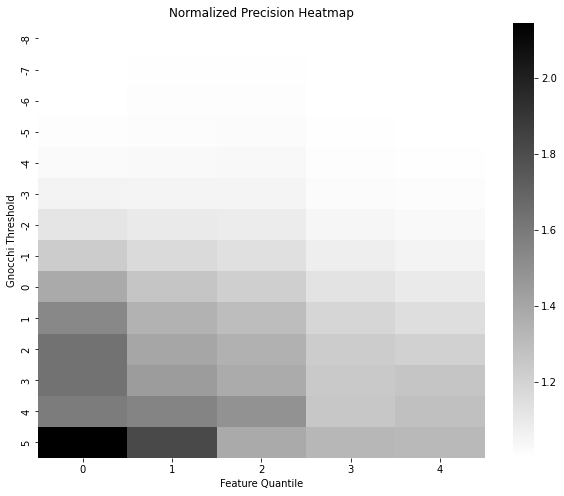

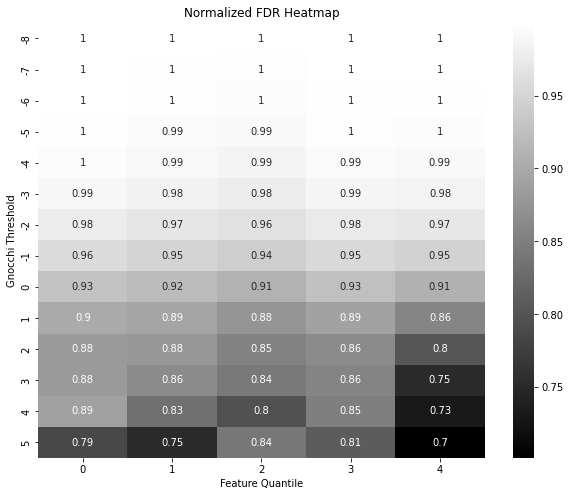

In [42]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt

def g(df, feature='GC_content_1000bp'): 
  df = df.copy()

  df[f'{feature}_quantile'] = pd.qcut(df[feature], q=5, labels=False)
  feature_quantiles = np.sort(df[f'{feature}_quantile'].unique())

  gnocchi_thresholds = range(-8, 6)

  normalized_precision_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_quantiles).astype(float)
  normalized_FDR_df = pd.DataFrame(index=gnocchi_thresholds, columns=feature_quantiles).astype(float)

  for feature_quantile in feature_quantiles:
    df_feature_quantile = df[df[f'{feature}_quantile'] == feature_quantile]
    r = df_feature_quantile['window overlaps enhancer'].mean()
    print(feature_quantile, df_feature_quantile[feature].mean(), r)
    for gnocchi_threshold in gnocchi_thresholds:
      TP = df_feature_quantile[
        (df_feature_quantile['gnocchi'] > gnocchi_threshold) & 
        (df_feature_quantile['window overlaps enhancer'] == True)
      ].shape[0]
      FP = df_feature_quantile[
        (df_feature_quantile['gnocchi'] > gnocchi_threshold) & 
        (df_feature_quantile['window overlaps enhancer'] == False)
      ].shape[0]
      precision = TP / (TP + FP)
      FDR = 1 - precision
      normalized_precision_df.loc[gnocchi_threshold, feature_quantile] = precision/r
      normalized_FDR_df.loc[gnocchi_threshold, feature_quantile] = FDR/(1-r)

  plt.figure(figsize=(10, 8))
  sns.heatmap(normalized_precision_df, annot=False, cmap='binary')
  plt.title('Normalized Precision Heatmap')
  plt.xlabel('Feature Quantile')
  plt.ylabel('Gnocchi Threshold')
  plt.show()

  plt.figure(figsize=(10, 8))
  sns.heatmap(normalized_FDR_df, annot=True, cmap='binary_r')
  plt.title('Normalized FDR Heatmap')
  plt.xlabel('Feature Quantile')
  plt.ylabel('Gnocchi Threshold')
  plt.show()

g(WINDOWS)

In [44]:
0.875/0.91

0.9615384615384615

In [45]:
0.85/0.91

0.934065934065934